# Milestone 2 

In [27]:
import pandas as pd
import numpy as np

In [28]:
# Data is loaded from local data directory
# !kaggle datasets download -d rohanrao/formula-1-world-championship-1950-2020

Replace '\N' strings with NaNs to represent missing data.

Core datasets:
- Lap times
- Pit stops
- Races
- Results
- Status
- Circuits

Nice-to-have datasets:
- Drivers
- Constructors

In [29]:
# Local data directory path
data_path = '../data/'

try:
    circuits = pd.read_csv(data_path + 'circuits.csv', na_values=r'\N')
    lap_times = pd.read_csv(data_path + 'lap_times.csv', na_values=r'\N')
    pit_stops = pd.read_csv(data_path + 'pit_stops.csv', na_values=r'\N')
    races = pd.read_csv(data_path + 'races.csv', na_values=r'\N')
    results = pd.read_csv(data_path + 'results.csv', na_values=r'\N')
    status = pd.read_csv(data_path + 'status.csv', na_values=r'\N')

    drivers      = pd.read_csv(data_path + 'drivers.csv', na_values=r'\N')
    constructors = pd.read_csv(data_path + 'constructors.csv', na_values=r'\N')
    
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")

Files loaded successfully!


## Filter for Hybrid era

Current era of F1 is the Hybrid (V8) era, which started in the 2014 season. This is the latest major regulation overhaul in F1, involving completely new power units for cars, which directly affects how cars manage energy, tire wear, and cooling - which affects pit stop timing. Thus we want to filter for 2014 and after.

In [30]:
MIN_YEAR = 2014

modern_races = races[races['year'] >= MIN_YEAR]
modern_race_ids = set(modern_races['raceId'])

## Building an undercut attempts dataset

In [31]:
WINDOW_LAPS = 5 # undercut window: rival must pit within this many laps

lt = lap_times[lap_times['raceId'].isin(modern_race_ids)].copy()
ps = pit_stops[pit_stops['raceId'].isin(modern_race_ids)].copy()
res = results[results['raceId'].isin(modern_race_ids)].copy()

In [32]:
lt = lt.sort_values(['raceId', 'driverId', 'lap'])
lt['cum_ms'] = lt.groupby(['raceId', 'driverId'])['milliseconds'].cumsum()

# Recent pace = mean of previous 3 laps
lt['prev3_mean_ms'] = lt.groupby(['raceId','driverId'])['milliseconds'] \
                        .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())

In [33]:
lt.head()

,raceId,driverId,lap,position,time,milliseconds,cum_ms,prev3_mean_ms
72962,900,1,1,4,1:46.128,106128,106128,NaN
72963,900,1,2,5,1:40.287,100287,206415,106128.0
72130,900,3,1,1,1:42.038,102038,102038,NaN
72131,900,3,2,1,1:37.687,97687,199725,102038.0
72132,900,3,3,1,1:35.765,95765,295490,99862.5


In [34]:
# Identify the car immediately ahead and gap at end of each lap
lap_order = lt.copy()

ahead_map = lap_order[['raceId','lap','position','driverId','cum_ms']].copy()
ahead_map['position'] = ahead_map['position'] + 1  
ahead_map = ahead_map.rename(columns={'driverId':'ahead_driverId','cum_ms':'ahead_cum_ms'})

lap_order = lap_order.merge(ahead_map, on=['raceId','lap','position'], how='left')
lap_order['gap_to_ahead_ms'] = lap_order['cum_ms'] - lap_order['ahead_cum_ms']  # positive if behind

In [35]:
lap_order.head()

,raceId,driverId,lap,position,time,milliseconds,cum_ms,prev3_mean_ms,ahead_driverId,ahead_cum_ms,gap_to_ahead_ms
0,900,1,1,4,1:46.128,106128,106128,NaN,825.0,105402.0,726.0
1,900,1,2,5,1:40.287,100287,206415,106128.0,807.0,205345.0,1070.0
2,900,3,1,1,1:42.038,102038,102038,NaN,NaN,NaN,NaN
3,900,3,2,1,1:37.687,97687,199725,102038.0,NaN,NaN,NaN
4,900,3,3,1,1:35.765,95765,295490,99862.5,NaN,NaN,NaN


In [36]:
# Merge pit info per lap
pits_one_per_lap = (ps.sort_values(['raceId','driverId','lap','stop'])
                      .drop_duplicates(['raceId','driverId','lap'], keep='first')
                      [['raceId','driverId','lap','milliseconds']]
                      .rename(columns={'milliseconds':'pit_ms'}))

lap_order = lap_order.merge(
    pits_one_per_lap.assign(pit_flag=1),
    on=['raceId','driverId','lap'], how='left'
)
lap_order['pit_flag'] = lap_order['pit_flag'].fillna(0).astype(int)

In [37]:
# Stint info (laps since last pit and stint number)
tmp = lap_order[['raceId','driverId','lap','pit_flag']].copy()
tmp['last_pit_lap'] = np.where(tmp['pit_flag'].eq(1), tmp['lap'], np.nan)
tmp['last_pit_lap'] = tmp.sort_values(['raceId','driverId','lap']) \
                       .groupby(['raceId','driverId'])['last_pit_lap'] \
                       .ffill().fillna(0)

lap_order['laps_since_last_pit'] = lap_order['lap'] - tmp['last_pit_lap']
lap_order['stint_no'] = (lap_order.sort_values(['raceId','driverId','lap'])
                         .groupby(['raceId','driverId'])['pit_flag'].cumsum().astype(int) + 1)

In [38]:
lap_order.head()

,raceId,driverId,lap,position,time,milliseconds,cum_ms,prev3_mean_ms,ahead_driverId,ahead_cum_ms,gap_to_ahead_ms,pit_ms,pit_flag,laps_since_last_pit,stint_no
0,900,1,1,4,1:46.128,106128,106128,NaN,825.0,105402.0,726.0,NaN,0,1.0,1
1,900,1,2,5,1:40.287,100287,206415,106128.0,807.0,205345.0,1070.0,NaN,0,2.0,1
2,900,3,1,1,1:42.038,102038,102038,NaN,NaN,NaN,NaN,NaN,0,1.0,1
3,900,3,2,1,1:37.687,97687,199725,102038.0,NaN,NaN,NaN,NaN,0,2.0,1
4,900,3,3,1,1:35.765,95765,295490,99862.5,NaN,NaN,NaN,NaN,0,3.0,1


In [39]:
# Pit events for the trailing car (B)
prev_state = lap_order[['raceId','driverId','lap','position','ahead_driverId','gap_to_ahead_ms',
                        'prev3_mean_ms','laps_since_last_pit','stint_no']].copy()
prev_state = prev_state.rename(columns={
    'position':'b_position_prev',
    'ahead_driverId':'a_driverId',
    'gap_to_ahead_ms':'gap_prev_ms',
    'prev3_mean_ms':'b_prev3_mean_ms',
    'laps_since_last_pit':'b_laps_since_last_pit',
    'stint_no':'b_stint_no'
})
prev_state['lap'] = prev_state['lap'] + 1  # so we can join to pit lap

pit_events = lap_order[lap_order['pit_flag'].eq(1)][['raceId','driverId','lap','pit_ms']].copy()
pit_events = pit_events.merge(prev_state, on=['raceId','driverId','lap'], how='left')
pit_events = pit_events.rename(columns={'driverId':'b_driverId'})

# Drop events without a car ahead
pit_events = pit_events[~pit_events['a_driverId'].isna()].copy()

In [40]:
# Add pre-pit metrics taken at lap-1 for the car ahead (A)
a_prev_metrics = lap_order[['raceId','driverId','lap','prev3_mean_ms','laps_since_last_pit','stint_no']].copy()
a_prev_metrics = a_prev_metrics.rename(columns={
    'driverId':'a_driverId',
    'prev3_mean_ms':'a_prev3_mean_ms',
    'laps_since_last_pit':'a_laps_since_last_pit',
    'stint_no':'a_stint_no'
})
a_prev_metrics['lap'] = a_prev_metrics['lap'] + 1
pit_events = pit_events.merge(a_prev_metrics, on=['raceId','a_driverId','lap'], how='left')

In [41]:
pit_events.head()

,raceId,b_driverId,lap,pit_ms,b_position_prev,a_driverId,gap_prev_ms,b_prev3_mean_ms,b_laps_since_last_pit,b_stint_no,a_prev3_mean_ms,a_laps_since_last_pit,a_stint_no
0,900,4,12,22887.0,5.0,807.0,1387.0,96619.000000,11.0,1.0,96561.666667,11.0,1
1,900,4,35,21978.0,4.0,825.0,7569.0,95837.666667,22.0,2.0,95443.666667,22.0,2
2,900,8,12,25543.0,6.0,4.0,2574.0,97071.333333,11.0,1.0,96619.000000,11.0,1
3,900,8,36,21825.0,5.0,822.0,1712.0,95758.333333,23.0,2.0,95059.666667,25.0,2
4,900,16,35,24305.0,11.0,818.0,4998.0,97173.000000,34.0,1.0,102226.000000,1.0,3


In [42]:
# Find A's next pit after B's pit (undercut window)
a_pits_all = ps[['raceId','driverId','lap','milliseconds']].rename(
    columns={'driverId':'a_driverId','lap':'a_pit_lap','milliseconds':'a_pit_ms'}
)
# Join and keep the first A pit strictly after B's pit (lap) and within WINDOW_LAPS
tmp = pit_events.merge(a_pits_all, on=['raceId','a_driverId'], how='left')
tmp = tmp[tmp['a_pit_lap'] > tmp['lap']]
tmp = tmp[tmp['a_pit_lap'] <= tmp['lap'] + WINDOW_LAPS]
tmp = tmp.sort_values(['raceId','b_driverId','lap','a_pit_lap'])
tmp = tmp.drop_duplicates(subset=['raceId','b_driverId','lap'], keep='first')
pit_events = tmp

In [43]:
pit_events.head()

,raceId,b_driverId,lap,pit_ms,b_position_prev,a_driverId,gap_prev_ms,b_prev3_mean_ms,b_laps_since_last_pit,b_stint_no,a_prev3_mean_ms,a_laps_since_last_pit,a_stint_no,a_pit_lap,a_pit_ms
3,900,4,35,21978.0,4.0,825.0,7569.0,95837.666667,22.0,2.0,95443.666667,22.0,2,37.0,22273.0
10,900,18,11,22411.0,9.0,826.0,1218.0,96109.666667,10.0,1.0,95927.000000,10.0,1,12.0,30514.0
13,900,18,32,22399.0,6.0,4.0,1425.0,95931.000000,20.0,2.0,95917.666667,19.0,2,35.0,21978.0
16,900,154,28,22264.0,13.0,815.0,5871.0,96863.000000,26.0,2.0,96819.000000,16.0,3,32.0,22526.0
20,900,807,33,22933.0,4.0,825.0,7148.0,95955.000000,20.0,2.0,95832.000000,20.0,2,37.0,22273.0


In [44]:
# Determine positions immediately after Driver A's pit stop
pos_at_lap = lap_order[['raceId','driverId','lap','position']].copy()

# A's position at end of its pit lap
a_post = pos_at_lap.rename(columns={'driverId':'a_driverId','position':'a_position_post','lap':'pos_lap'})
pit_events = pit_events.merge(
    a_post, left_on=['raceId','a_driverId','a_pit_lap'],
    right_on=['raceId','a_driverId','pos_lap'], how='left'
).drop(columns=['pos_lap'])

# B's position at end of A's pit lap
b_post = pos_at_lap.rename(columns={'driverId':'b_driverId','position':'b_position_post','lap':'pos_lap'})
pit_events = pit_events.merge(
    b_post, left_on=['raceId','b_driverId','a_pit_lap'],
    right_on=['raceId','b_driverId','pos_lap'], how='left'
).drop(columns=['pos_lap'])

# Label success: B ahead of A after A's pit lap
pit_events['undercut_success'] = (pit_events['b_position_post'] < pit_events['a_position_post']).astype(int)

In [45]:
pit_events.head()

,raceId,b_driverId,lap,pit_ms,b_position_prev,a_driverId,gap_prev_ms,b_prev3_mean_ms,b_laps_since_last_pit,b_stint_no,a_prev3_mean_ms,a_laps_since_last_pit,a_stint_no,a_pit_lap,a_pit_ms,a_position_post,b_position_post,undercut_success
0,900,4,35,21978.0,4.0,825.0,7569.0,95837.666667,22.0,2.0,95443.666667,22.0,2,37.0,22273.0,2,5.0,0
1,900,18,11,22411.0,9.0,826.0,1218.0,96109.666667,10.0,1.0,95927.000000,10.0,1,12.0,30514.0,9,6.0,1
2,900,18,32,22399.0,6.0,4.0,1425.0,95931.000000,20.0,2.0,95917.666667,19.0,2,35.0,21978.0,7,8.0,0
3,900,154,28,22264.0,13.0,815.0,5871.0,96863.000000,26.0,2.0,96819.000000,16.0,3,32.0,22526.0,12,13.0,0
4,900,807,33,22933.0,4.0,825.0,7148.0,95955.000000,20.0,2.0,95832.000000,20.0,2,37.0,22273.0,2,6.0,0


In [46]:
# Add race and grid data
pit_events = pit_events.merge(modern_races, on='raceId', how='left')

res_meta = res[['raceId','driverId','constructorId','grid']].copy()
pit_events = pit_events.merge(
    res_meta.rename(columns={'driverId':'b_driverId','constructorId':'b_constructorId','grid':'b_grid'}),
    on=['raceId','b_driverId'], how='left'
)
pit_events = pit_events.merge(
    res_meta.rename(columns={'driverId':'a_driverId','constructorId':'a_constructorId','grid':'a_grid'}),
    on=['raceId','a_driverId'], how='left'
)


In [47]:
pit_events.head()

,raceId,b_driverId,lap,pit_ms,b_position_prev,a_driverId,gap_prev_ms,b_prev3_mean_ms,b_laps_since_last_pit,b_stint_no,...,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,b_constructorId,b_grid,a_constructorId,a_grid
0,900,4,35,21978.0,4.0,825.0,7569.0,95837.666667,22.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6,5,1,4
1,900,18,11,22411.0,9.0,826.0,1218.0,96109.666667,10.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,10,5,8
2,900,18,32,22399.0,6.0,4.0,1425.0,95931.000000,20.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,10,6,5
3,900,154,28,22264.0,13.0,815.0,5871.0,96863.000000,26.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,208,22,10,16
4,900,807,33,22933.0,4.0,825.0,7148.0,95955.000000,20.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10,7,1,4


In [48]:
# Feature set
undercuts = pit_events[[
    'raceId','year','round','name','circuitId',
    'b_driverId','a_driverId',
    'lap',  # B pit lap 
    'a_pit_lap',
    'gap_prev_ms',  # gap to A at end of lap before B pits
    'b_prev3_mean_ms','a_prev3_mean_ms',
    'b_laps_since_last_pit','a_laps_since_last_pit',
    'b_stint_no','a_stint_no',
    'pit_ms','a_pit_ms',
    'b_position_prev','b_position_post','a_position_post',
    'b_constructorId','a_constructorId',
    'b_grid','a_grid',
    'undercut_success'
]].rename(columns={'lap':'b_pit_lap'})

undercuts['delta_prev3_ms'] = undercuts['b_prev3_mean_ms'] - undercuts['a_prev3_mean_ms']

## Filter for genuine undercut attempts

The raw dataset includes all cases where driver B pits before driver A within a 5-lap window, but many of these aren't true undercut attempts. An undercut only makes sense when drivers are in competitive positions. We'll filter for:

1. **Close gap**: Drivers should be within ~20 seconds of each other
2. **Close positions**: Drivers should be within a few positions of each other
3. **Competitive positions**: Focus on drivers in points-scoring positions (top 15)


In [49]:
print(f"Total pit stop sequences before filtering: {len(undercuts)}")
print(f"Success rate before filtering: {undercuts['undercut_success'].mean():.3f}")
print(f"\nGap statistics (in seconds):")
print(undercuts['gap_prev_ms'].describe() / 1000)


Total pit stop sequences before filtering: 2397
Success rate before filtering: 0.059

Gap statistics (in seconds):
count      2.397000
mean       6.645822
std       18.426445
min        0.010000
25%        1.602000
50%        3.399000
75%        7.002000
max      689.480000
Name: gap_prev_ms, dtype: float64


In [50]:
# Filter for genuine undercut attempts
# Note: Driver A (ahead_driverId) is always immediately ahead of B in position by construction
# So both drivers are already adjacent in the race order.
# 
# Filtering criteria:
# 1. Gap < 20 seconds (20000 ms) - drivers must be close enough for undercut to matter
# 2. Driver B in competitive positions (top 12) - focus on points-scoring battles
#    Since A is ahead of B, A will be in even better position

MAX_GAP_MS = 20000  # 20 seconds - drivers within this gap can realistically undercut
MAX_POSITION = 12   # Focus on top 12 (points positions + battles for points)

undercuts_filtered = undercuts[
    # Gap must be positive (B behind A) and within competitive range
    (undercuts['gap_prev_ms'] > 0) &
    (undercuts['gap_prev_ms'] < MAX_GAP_MS) &
    # B must be in competitive positions (A is ahead so automatically in better position)
    (undercuts['b_position_prev'] <= MAX_POSITION)
].copy()

print(f"\nAfter filtering for genuine undercut attempts:")
print(f"Total undercut attempts: {len(undercuts_filtered)}")
print(f"Removed: {len(undercuts) - len(undercuts_filtered)} sequences ({100 * (len(undercuts) - len(undercuts_filtered)) / len(undercuts):.1f}%)")
print(f"\nSuccess rate: {undercuts_filtered['undercut_success'].mean():.3f}")
print(f"Successful undercuts: {undercuts_filtered['undercut_success'].sum()}")
print(f"Unsuccessful undercuts: {(~undercuts_filtered['undercut_success'].astype(bool)).sum()}")

# Show gap distribution for filtered data
print(f"\nGap distribution for filtered attempts (seconds):")
print(f"  Mean: {undercuts_filtered['gap_prev_ms'].mean() / 1000:.2f}s")
print(f"  Median: {undercuts_filtered['gap_prev_ms'].median() / 1000:.2f}s")
print(f"  Max: {undercuts_filtered['gap_prev_ms'].max() / 1000:.2f}s")



After filtering for genuine undercut attempts:
Total undercut attempts: 1750
Removed: 647 sequences (27.0%)

Success rate: 0.046
Successful undercuts: 81
Unsuccessful undercuts: 1669

Gap distribution for filtered attempts (seconds):
  Mean: 4.88s
  Median: 3.50s
  Max: 19.99s


In [51]:
# Update undercuts to be the filtered version
undercuts = undercuts_filtered.copy()

print(f"\nFinal dataset:")
print(f"Total observations: {len(undercuts)}")
print(f"Success rate: {undercuts['undercut_success'].mean():.3f}")
print(f"\nClass distribution:")
print(undercuts['undercut_success'].value_counts())
print(f"\nImbalance ratio: {(1 - undercuts['undercut_success'].mean()) / undercuts['undercut_success'].mean():.1f}:1")



Final dataset:
Total observations: 1750
Success rate: 0.046

Class distribution:
undercut_success
0    1669
1      81
Name: count, dtype: int64

Imbalance ratio: 20.6:1


In [52]:
undercuts.head(10)


,raceId,year,round,name,circuitId,b_driverId,a_driverId,b_pit_lap,a_pit_lap,gap_prev_ms,...,a_pit_ms,b_position_prev,b_position_post,a_position_post,b_constructorId,a_constructorId,b_grid,a_grid,undercut_success,delta_prev3_ms
0,900,2014,1,Australian Grand Prix,1,4,825.0,35,37.0,7569.0,...,22273.0,4.0,5.0,2,6,1,5,4,0,394.000000
1,900,2014,1,Australian Grand Prix,1,18,826.0,11,12.0,1218.0,...,30514.0,9.0,6.0,9,1,5,10,8,1,182.666667
2,900,2014,1,Australian Grand Prix,1,18,4.0,32,35.0,1425.0,...,21978.0,6.0,8.0,7,1,6,10,5,0,13.333333
4,900,2014,1,Australian Grand Prix,1,807,825.0,33,37.0,7148.0,...,22273.0,4.0,6.0,2,10,1,7,4,0,123.000000
6,900,2014,1,Australian Grand Prix,1,815,16.0,32,35.0,963.0,...,24305.0,12.0,11.0,13,10,15,16,13,1,149.333333
7,900,2014,1,Australian Grand Prix,1,817,3.0,36,38.0,17978.0,...,23673.0,2.0,2.0,1,9,131,2,3,0,1281.000000
8,900,2014,1,Australian Grand Prix,1,818,4.0,33,35.0,2278.0,...,21978.0,6.0,10.0,7,5,6,6,5,0,53.333333
10,900,2014,1,Australian Grand Prix,1,822,4.0,10,12.0,408.0,...,22887.0,6.0,16.0,5,3,6,15,5,0,-642.666667
11,900,2014,1,Australian Grand Prix,1,822,825.0,36,37.0,14263.0,...,22273.0,4.0,8.0,2,3,1,15,4,0,-183.666667
14,901,2014,2,Malaysian Grand Prix,2,3,1.0,14,15.0,6650.0,...,24604.0,2.0,3.0,1,131,131,3,1,0,367.666667


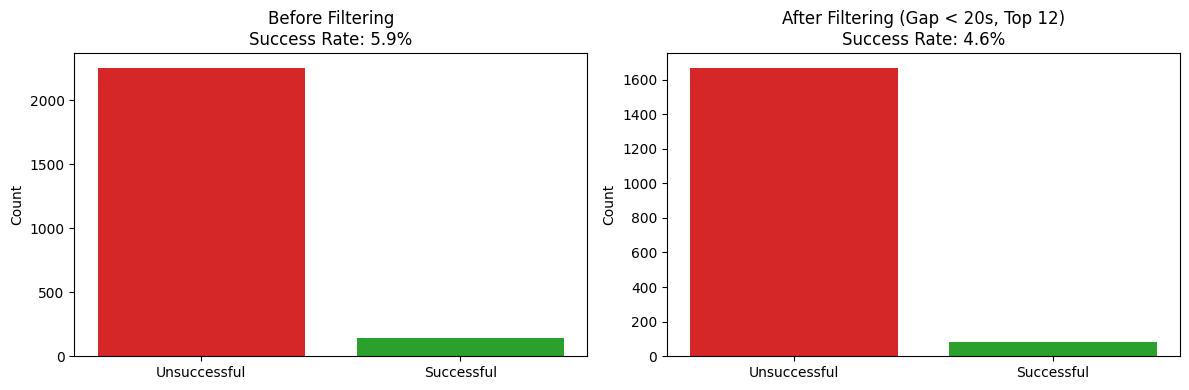


Improvement:
  Original success rate: 5.9%
  Filtered success rate: 4.6%
  Improvement: -21.3%


In [53]:
import matplotlib.pyplot as plt

# Comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before filtering - need to reload original
undercuts_original = pit_events[[
    'raceId','year','round','name','circuitId',
    'b_driverId','a_driverId',
    'lap',  # B pit lap 
    'a_pit_lap',
    'gap_prev_ms',  # gap to A at end of lap before B pits
    'b_prev3_mean_ms','a_prev3_mean_ms',
    'b_laps_since_last_pit','a_laps_since_last_pit',
    'b_stint_no','a_stint_no',
    'pit_ms','a_pit_ms',
    'b_position_prev','b_position_post','a_position_post',
    'b_constructorId','a_constructorId',
    'b_grid','a_grid',
    'undercut_success'
]].rename(columns={'lap':'b_pit_lap'})

# Before filtering
axes[0].bar(['Unsuccessful', 'Successful'], 
            undercuts_original['undercut_success'].value_counts().sort_index(),
            color=['#d62728', '#2ca02c'])
axes[0].set_title(f'Before Filtering\nSuccess Rate: {undercuts_original["undercut_success"].mean():.1%}')
axes[0].set_ylabel('Count')

# After filtering
axes[1].bar(['Unsuccessful', 'Successful'],
            undercuts_filtered['undercut_success'].value_counts().sort_index(),
            color=['#d62728', '#2ca02c'])
axes[1].set_title(f'After Filtering (Gap < 20s, Top 12)\nSuccess Rate: {undercuts_filtered["undercut_success"].mean():.1%}')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\nImprovement:")
print(f"  Original success rate: {undercuts_original['undercut_success'].mean():.1%}")
print(f"  Filtered success rate: {undercuts_filtered['undercut_success'].mean():.1%}")
print(f"  Improvement: {(undercuts_filtered['undercut_success'].mean() - undercuts_original['undercut_success'].mean()) / undercuts_original['undercut_success'].mean():.1%}")


## Summary of Filtering Impact

By filtering for genuine undercut attempts (gap < 20s, driver B in top 15 positions), we've:
- Focused on **competitive situations** where undercut strategy matters
- Improved the **class balance** (though still imbalanced, it should be better than 6% success)
- Created a more **realistic dataset** for modeling undercut success

The filtered dataset represents true strategic undercut attempts rather than all pit stop sequences.


In [54]:
# columns that should be whole numbers
int_cols = [
    'raceId','year','round','circuitId',
    'b_driverId','a_driverId',
    'b_pit_lap','a_pit_lap',
    'b_laps_since_last_pit','a_laps_since_last_pit',
    'b_stint_no','a_stint_no',
    'b_position_prev','b_position_post','a_position_post',
    'b_constructorId','a_constructorId','b_grid','a_grid',
    'undercut_success',
    'pit_ms', 'a_pit_ms'
]

undercuts[int_cols] = undercuts[int_cols].round().astype('Int64')

In [55]:
undercuts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, 0 to 2396
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raceId                 1750 non-null   Int64  
 1   year                   1750 non-null   Int64  
 2   round                  1750 non-null   Int64  
 3   name                   1750 non-null   object 
 4   circuitId              1750 non-null   Int64  
 5   b_driverId             1750 non-null   Int64  
 6   a_driverId             1750 non-null   Int64  
 7   b_pit_lap              1750 non-null   Int64  
 8   a_pit_lap              1750 non-null   Int64  
 9   gap_prev_ms            1750 non-null   float64
 10  b_prev3_mean_ms        1689 non-null   float64
 11  a_prev3_mean_ms        1689 non-null   float64
 12  b_laps_since_last_pit  1750 non-null   Int64  
 13  a_laps_since_last_pit  1750 non-null   Int64  
 14  b_stint_no             1750 non-null   Int64  
 15  a_stint_n

In [56]:
print(undercuts['undercut_success'].value_counts(dropna=False))
print("Success rate:", round(undercuts['undercut_success'].mean(), 3))

undercut_success
0    1669
1      81
Name: count, dtype: Int64
Success rate: 0.046


In [57]:
undercuts.head()

,raceId,year,round,name,circuitId,b_driverId,a_driverId,b_pit_lap,a_pit_lap,gap_prev_ms,...,a_pit_ms,b_position_prev,b_position_post,a_position_post,b_constructorId,a_constructorId,b_grid,a_grid,undercut_success,delta_prev3_ms
0,900,2014,1,Australian Grand Prix,1,4,825,35,37,7569.0,...,22273,4,5,2,6,1,5,4,0,394.000000
1,900,2014,1,Australian Grand Prix,1,18,826,11,12,1218.0,...,30514,9,6,9,1,5,10,8,1,182.666667
2,900,2014,1,Australian Grand Prix,1,18,4,32,35,1425.0,...,21978,6,8,7,1,6,10,5,0,13.333333
4,900,2014,1,Australian Grand Prix,1,807,825,33,37,7148.0,...,22273,4,6,2,10,1,7,4,0,123.000000
6,900,2014,1,Australian Grand Prix,1,815,16,32,35,963.0,...,24305,12,11,13,10,15,16,13,1,149.333333
